In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial',
 'NT_Muscle',
 'NT_stroma',
 'NT_immune',
 'NT_intestinal_metaplasia']
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
img_path='../../data/area_segmentation/STNT/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image/','/mask/npy/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)
np_mask=np.zeros((img_size,img_size,len(class_list)))
for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=np.load(train_mask_list[i]).astype(np.uint8)
    one_hot_mask = np.zeros((1024, 1024, len(class_list)+1), dtype=np.int32)

        # 각 위치에 대해 mask 값에 해당하는 채널에 1을 설정
    np.put_along_axis(one_hot_mask, np_mask[..., np.newaxis], 1, axis=2)
    np_mask=one_hot_mask
    train_mask[i]=tf(np_mask)
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=np.load(test_mask_list[i]).astype(np.uint8)
    one_hot_mask = np.zeros((1024, 1024, len(class_list)+1), dtype=np.int32)

        # 각 위치에 대해 mask 값에 해당하는 채널에 1을 설정
    np.put_along_axis(one_hot_mask, np_mask[..., np.newaxis], 1, axis=2)
    np_mask=one_hot_mask
    test_mask[i]=tf(np_mask)


100%|██████████| 62/62 [00:11<00:00,  5.34it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(class_list)+1,                      # model output channels (number of classes in your dataset) 
    ).to(device)
def dice_loss(pred, target, num_classes=len(class_list)+1):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

# summary(model,(batch_size,3,img_size,img_size))

  0%|          | 0/123 [00:00<?, ?it/s]

epoch: 1/1000 Step: 124 dice_loss : 0.6685 dice_score: 0.3315: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 1/1000 Step: 32 dice_loss : 0.5794  dice_score: 0.4206: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]
epoch: 2/1000 Step: 124 dice_loss : 0.5788 dice_score: 0.4212: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 2/1000 Step: 32 dice_loss : 0.5487  dice_score: 0.4513: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]
epoch: 3/1000 Step: 124 dice_loss : 0.5497 dice_score: 0.4503: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 3/1000 Step: 32 dice_loss : 0.5513  dice_score: 0.4487: 100%|██████████| 31/31 [00:04<00:00,  6.63it/s]
epoch: 4/1000 Step: 124 dice_loss : 0.5212 dice_score: 0.4788: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 4/1000 Step: 32 dice_loss : 0.5374  dice_score: 0.4626: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 5/1000 Step: 124 dice_loss : 0.4988 dice_score: 0.5012: 100%|██████████| 123/

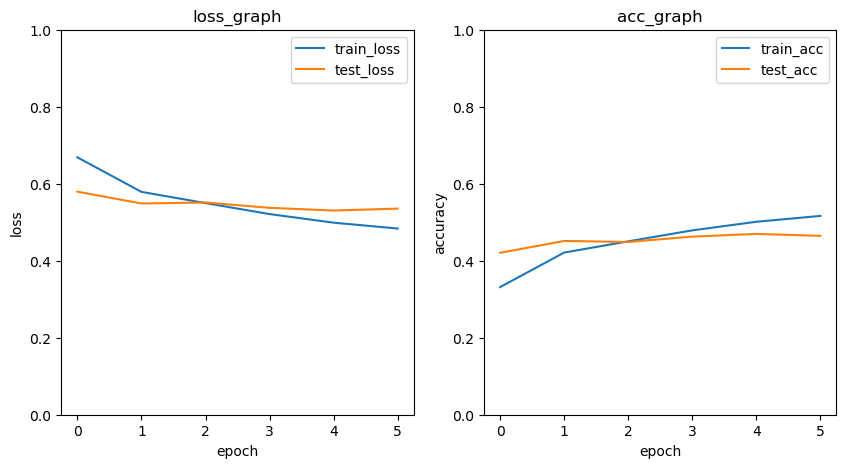

epoch: 7/1000 Step: 124 dice_loss : 0.4696 dice_score: 0.5304: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 7/1000 Step: 32 dice_loss : 0.5258  dice_score: 0.4742: 100%|██████████| 31/31 [00:04<00:00,  6.59it/s]
epoch: 8/1000 Step: 124 dice_loss : 0.4563 dice_score: 0.5437: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 8/1000 Step: 32 dice_loss : 0.5278  dice_score: 0.4722: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 9/1000 Step: 124 dice_loss : 0.4430 dice_score: 0.5570: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 9/1000 Step: 32 dice_loss : 0.5306  dice_score: 0.4694: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 10/1000 Step: 124 dice_loss : 0.4369 dice_score: 0.5631: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 10/1000 Step: 32 dice_loss : 0.5263  dice_score: 0.4737: 100%|██████████| 31/31 [00:04<00:00,  6.56it/s]
epoch: 11/1000 Step: 124 dice_loss : 0.4308 dice_score: 0.5692: 100%|██████████| 1

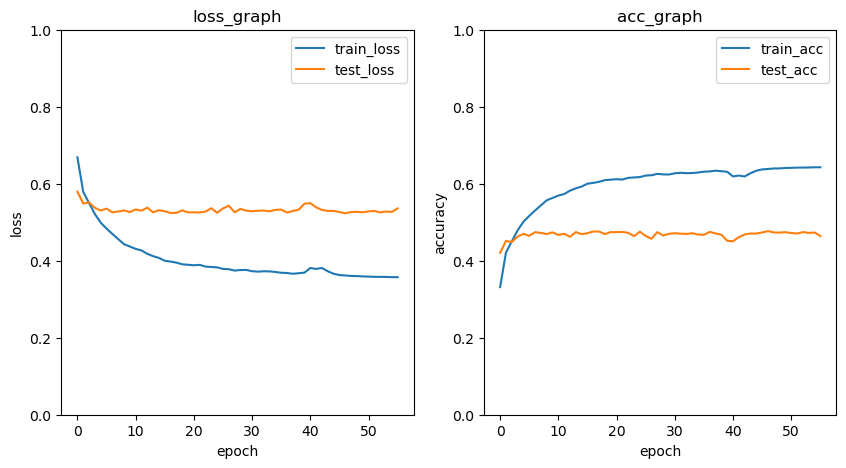

epoch: 57/1000 Step: 124 dice_loss : 0.3564 dice_score: 0.6436: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 57/1000 Step: 32 dice_loss : 0.5288  dice_score: 0.4712: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 58/1000 Step: 124 dice_loss : 0.3561 dice_score: 0.6439: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 58/1000 Step: 32 dice_loss : 0.5315  dice_score: 0.4685: 100%|██████████| 31/31 [00:04<00:00,  6.69it/s]
epoch: 59/1000 Step: 124 dice_loss : 0.3572 dice_score: 0.6428: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 59/1000 Step: 32 dice_loss : 0.5326  dice_score: 0.4674: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s]
epoch: 60/1000 Step: 124 dice_loss : 0.3588 dice_score: 0.6412: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 60/1000 Step: 32 dice_loss : 0.5314  dice_score: 0.4686: 100%|██████████| 31/31 [00:04<00:00,  6.50it/s]
epoch: 61/1000 Step: 124 dice_loss : 0.3569 dice_score: 0.6431: 100%|███████

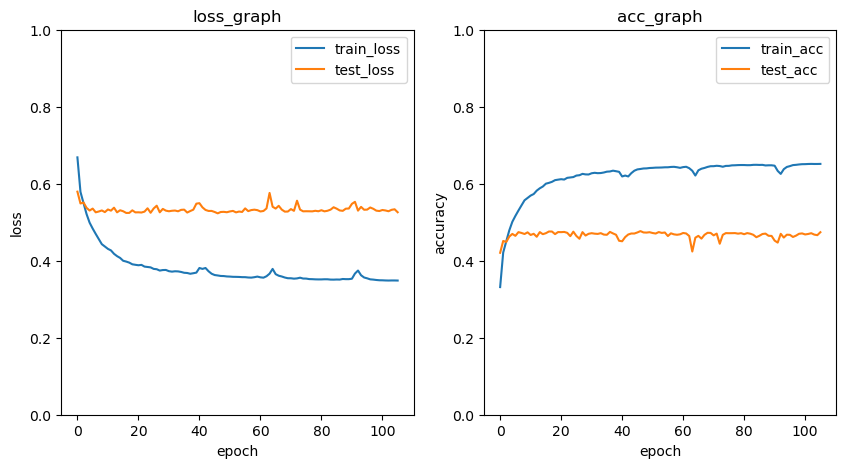

epoch: 107/1000 Step: 124 dice_loss : 0.3482 dice_score: 0.6518: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 107/1000 Step: 32 dice_loss : 0.5303  dice_score: 0.4697: 100%|██████████| 31/31 [00:04<00:00,  6.62it/s]
epoch: 108/1000 Step: 124 dice_loss : 0.3483 dice_score: 0.6517: 100%|██████████| 123/123 [01:03<00:00,  1.93it/s]
test epoch: 108/1000 Step: 32 dice_loss : 0.5327  dice_score: 0.4673: 100%|██████████| 31/31 [00:04<00:00,  6.54it/s]
epoch: 109/1000 Step: 124 dice_loss : 0.3480 dice_score: 0.6520: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 109/1000 Step: 32 dice_loss : 0.5344  dice_score: 0.4656: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 110/1000 Step: 124 dice_loss : 0.3479 dice_score: 0.6521: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 110/1000 Step: 32 dice_loss : 0.5333  dice_score: 0.4667: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 111/1000 Step: 124 dice_loss : 0.3478 dice_score: 0.6522: 100

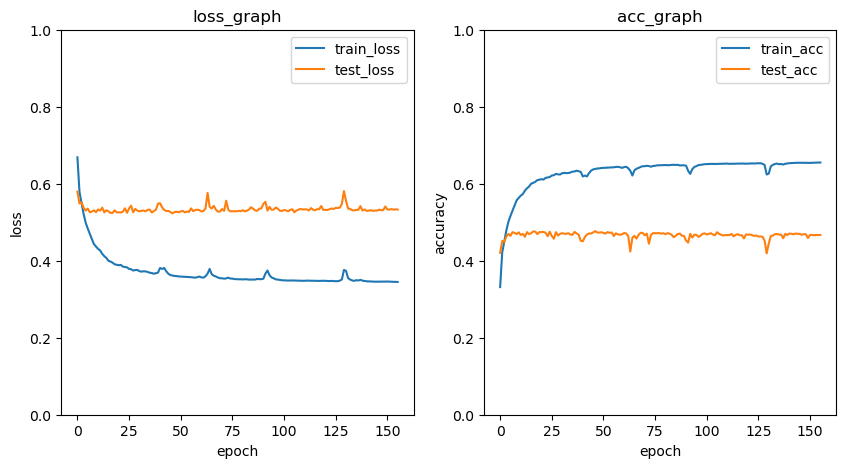

epoch: 157/1000 Step: 124 dice_loss : 0.3448 dice_score: 0.6552: 100%|██████████| 123/123 [01:02<00:00,  1.95it/s]
test epoch: 157/1000 Step: 32 dice_loss : 0.5359  dice_score: 0.4641: 100%|██████████| 31/31 [00:04<00:00,  6.86it/s]
epoch: 158/1000 Step: 124 dice_loss : 0.3450 dice_score: 0.6550: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 158/1000 Step: 32 dice_loss : 0.5347  dice_score: 0.4653: 100%|██████████| 31/31 [00:04<00:00,  6.68it/s]
epoch: 159/1000 Step: 124 dice_loss : 0.3450 dice_score: 0.6550: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 159/1000 Step: 32 dice_loss : 0.5323  dice_score: 0.4677: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 160/1000 Step: 124 dice_loss : 0.3449 dice_score: 0.6551: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 160/1000 Step: 32 dice_loss : 0.5346  dice_score: 0.4654: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 161/1000 Step: 124 dice_loss : 0.3450 dice_score: 0.6550: 100

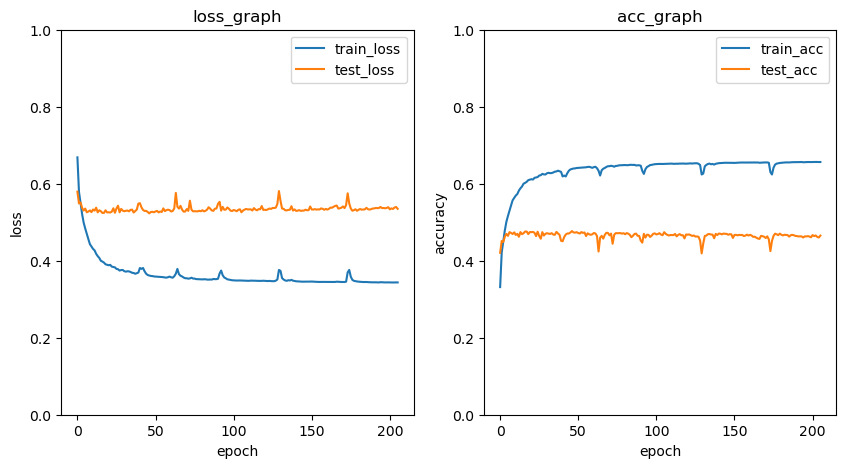

epoch: 207/1000 Step: 124 dice_loss : 0.3435 dice_score: 0.6565: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 207/1000 Step: 32 dice_loss : 0.5343  dice_score: 0.4657: 100%|██████████| 31/31 [00:04<00:00,  6.56it/s]
epoch: 208/1000 Step: 124 dice_loss : 0.3435 dice_score: 0.6565: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 208/1000 Step: 32 dice_loss : 0.5390  dice_score: 0.4610: 100%|██████████| 31/31 [00:04<00:00,  6.48it/s]
epoch: 209/1000 Step: 124 dice_loss : 0.3433 dice_score: 0.6567: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 209/1000 Step: 32 dice_loss : 0.5372  dice_score: 0.4628: 100%|██████████| 31/31 [00:04<00:00,  6.39it/s]
epoch: 210/1000 Step: 124 dice_loss : 0.3433 dice_score: 0.6567: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 210/1000 Step: 32 dice_loss : 0.5380  dice_score: 0.4620: 100%|██████████| 31/31 [00:04<00:00,  6.55it/s]
epoch: 211/1000 Step: 124 dice_loss : 0.3433 dice_score: 0.6567: 100

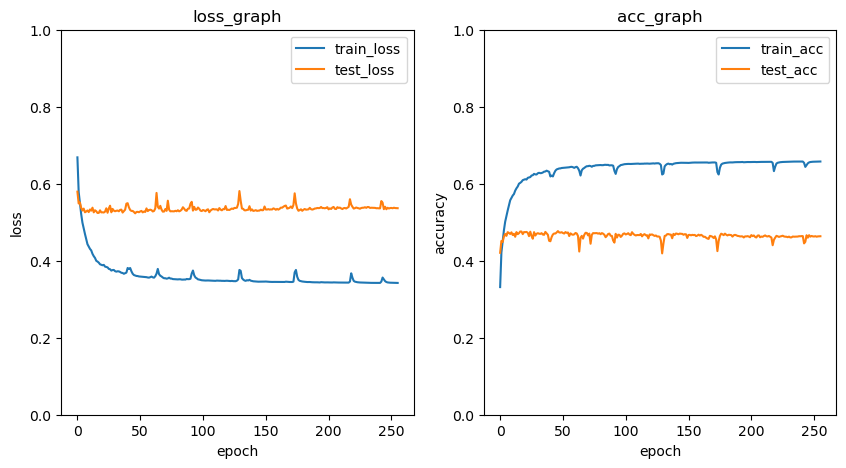

epoch: 257/1000 Step: 124 dice_loss : 0.3424 dice_score: 0.6576: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 257/1000 Step: 32 dice_loss : 0.5400  dice_score: 0.4600: 100%|██████████| 31/31 [00:04<00:00,  6.69it/s]
epoch: 258/1000 Step: 124 dice_loss : 0.3423 dice_score: 0.6577: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 258/1000 Step: 32 dice_loss : 0.5372  dice_score: 0.4628: 100%|██████████| 31/31 [00:04<00:00,  6.67it/s]
epoch: 259/1000 Step: 124 dice_loss : 0.3423 dice_score: 0.6577: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 259/1000 Step: 32 dice_loss : 0.5368  dice_score: 0.4632: 100%|██████████| 31/31 [00:04<00:00,  6.87it/s]
epoch: 260/1000 Step: 124 dice_loss : 0.3421 dice_score: 0.6579: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 260/1000 Step: 32 dice_loss : 0.5379  dice_score: 0.4621: 100%|██████████| 31/31 [00:04<00:00,  6.67it/s]
epoch: 261/1000 Step: 124 dice_loss : 0.3421 dice_score: 0.6579: 100

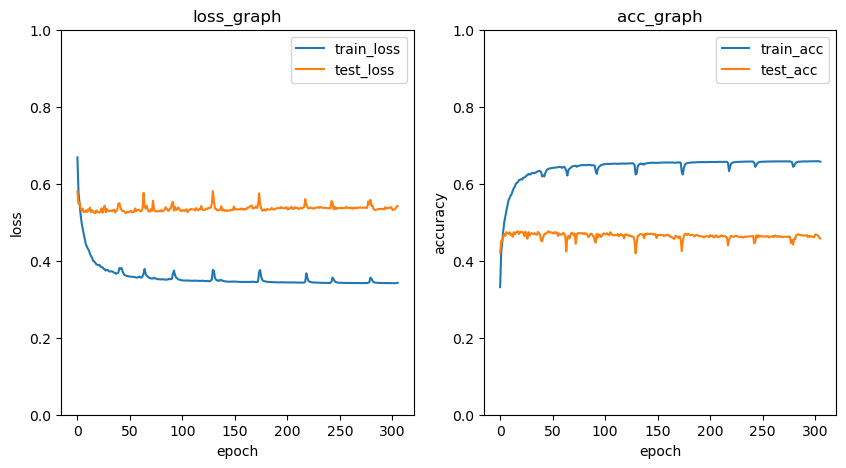

epoch: 307/1000 Step: 124 dice_loss : 0.3424 dice_score: 0.6576: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 307/1000 Step: 32 dice_loss : 0.5365  dice_score: 0.4635: 100%|██████████| 31/31 [00:04<00:00,  6.86it/s]
epoch: 308/1000 Step: 124 dice_loss : 0.3419 dice_score: 0.6581: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 308/1000 Step: 32 dice_loss : 0.5379  dice_score: 0.4621: 100%|██████████| 31/31 [00:04<00:00,  6.73it/s]
epoch: 309/1000 Step: 124 dice_loss : 0.3417 dice_score: 0.6583: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 309/1000 Step: 32 dice_loss : 0.5371  dice_score: 0.4629: 100%|██████████| 31/31 [00:04<00:00,  6.57it/s]
epoch: 310/1000 Step: 124 dice_loss : 0.3417 dice_score: 0.6583: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 310/1000 Step: 32 dice_loss : 0.5356  dice_score: 0.4644: 100%|██████████| 31/31 [00:04<00:00,  6.83it/s]
epoch: 311/1000 Step: 124 dice_loss : 0.3416 dice_score: 0.6584: 100

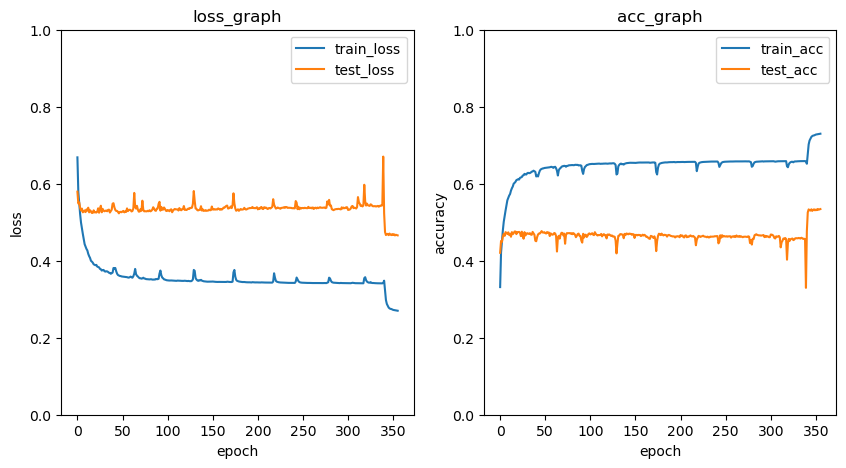

epoch: 357/1000 Step: 124 dice_loss : 0.2697 dice_score: 0.7303: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 357/1000 Step: 32 dice_loss : 0.4679  dice_score: 0.5321: 100%|██████████| 31/31 [00:04<00:00,  6.62it/s]
epoch: 358/1000 Step: 124 dice_loss : 0.2693 dice_score: 0.7307: 100%|██████████| 123/123 [01:03<00:00,  1.93it/s]
test epoch: 358/1000 Step: 32 dice_loss : 0.4672  dice_score: 0.5328: 100%|██████████| 31/31 [00:04<00:00,  6.61it/s]
epoch: 359/1000 Step: 124 dice_loss : 0.2691 dice_score: 0.7309: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 359/1000 Step: 32 dice_loss : 0.4670  dice_score: 0.5330: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s]
epoch: 360/1000 Step: 124 dice_loss : 0.2691 dice_score: 0.7309: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 360/1000 Step: 32 dice_loss : 0.4678  dice_score: 0.5322: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 361/1000 Step: 124 dice_loss : 0.2690 dice_score: 0.7310: 100

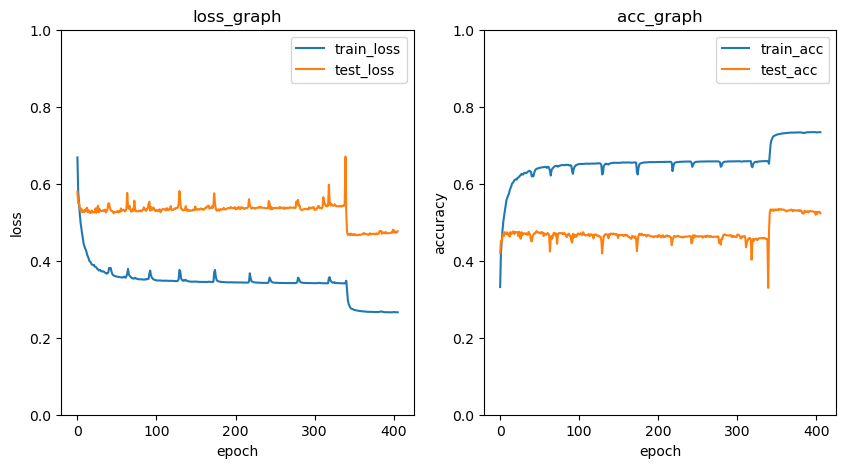

epoch: 407/1000 Step: 124 dice_loss : 0.2660 dice_score: 0.7340: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 407/1000 Step: 32 dice_loss : 0.4733  dice_score: 0.5267: 100%|██████████| 31/31 [00:04<00:00,  6.82it/s]
epoch: 408/1000 Step: 124 dice_loss : 0.2659 dice_score: 0.7341: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 408/1000 Step: 32 dice_loss : 0.4745  dice_score: 0.5255: 100%|██████████| 31/31 [00:04<00:00,  6.73it/s]
epoch: 409/1000 Step: 124 dice_loss : 0.2658 dice_score: 0.7342: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 409/1000 Step: 32 dice_loss : 0.4749  dice_score: 0.5251: 100%|██████████| 31/31 [00:04<00:00,  6.85it/s]
epoch: 410/1000 Step: 124 dice_loss : 0.2659 dice_score: 0.7341: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 410/1000 Step: 32 dice_loss : 0.4731  dice_score: 0.5269: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]
epoch: 411/1000 Step: 124 dice_loss : 0.2659 dice_score: 0.7341: 100

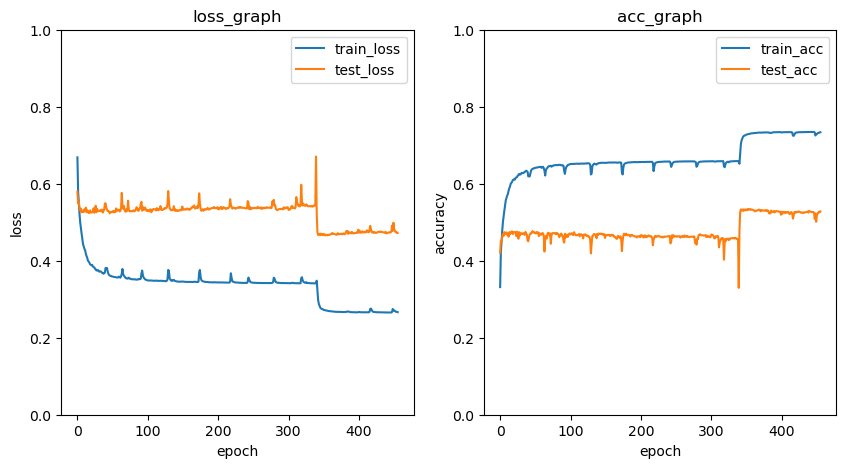

epoch: 457/1000 Step: 124 dice_loss : 0.2661 dice_score: 0.7339: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 457/1000 Step: 32 dice_loss : 0.4730  dice_score: 0.5270: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 458/1000 Step: 124 dice_loss : 0.2658 dice_score: 0.7342: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 458/1000 Step: 32 dice_loss : 0.4738  dice_score: 0.5262: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 459/1000 Step: 124 dice_loss : 0.2657 dice_score: 0.7343: 100%|██████████| 123/123 [01:02<00:00,  1.98it/s]
test epoch: 459/1000 Step: 32 dice_loss : 0.4729  dice_score: 0.5271: 100%|██████████| 31/31 [00:04<00:00,  6.56it/s]
epoch: 460/1000 Step: 124 dice_loss : 0.2657 dice_score: 0.7343: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 460/1000 Step: 32 dice_loss : 0.4730  dice_score: 0.5270: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 461/1000 Step: 124 dice_loss : 0.2656 dice_score: 0.7344: 100

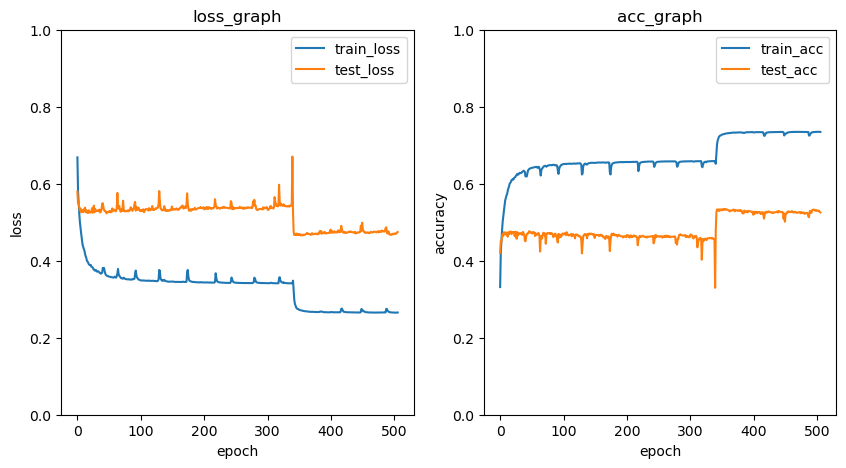

epoch: 507/1000 Step: 124 dice_loss : 0.2656 dice_score: 0.7344: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 507/1000 Step: 32 dice_loss : 0.4763  dice_score: 0.5237: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 508/1000 Step: 124 dice_loss : 0.2759 dice_score: 0.7241: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 508/1000 Step: 32 dice_loss : 0.5017  dice_score: 0.4983: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 509/1000 Step: 124 dice_loss : 0.2910 dice_score: 0.7090: 100%|██████████| 123/123 [01:02<00:00,  1.98it/s]
test epoch: 509/1000 Step: 32 dice_loss : 0.4957  dice_score: 0.5043: 100%|██████████| 31/31 [00:04<00:00,  6.78it/s]
epoch: 510/1000 Step: 124 dice_loss : 0.2822 dice_score: 0.7178: 100%|██████████| 123/123 [01:02<00:00,  1.98it/s]
test epoch: 510/1000 Step: 32 dice_loss : 0.4496  dice_score: 0.5504: 100%|██████████| 31/31 [00:04<00:00,  6.70it/s]
epoch: 511/1000 Step: 124 dice_loss : 0.2899 dice_score: 0.7101: 100

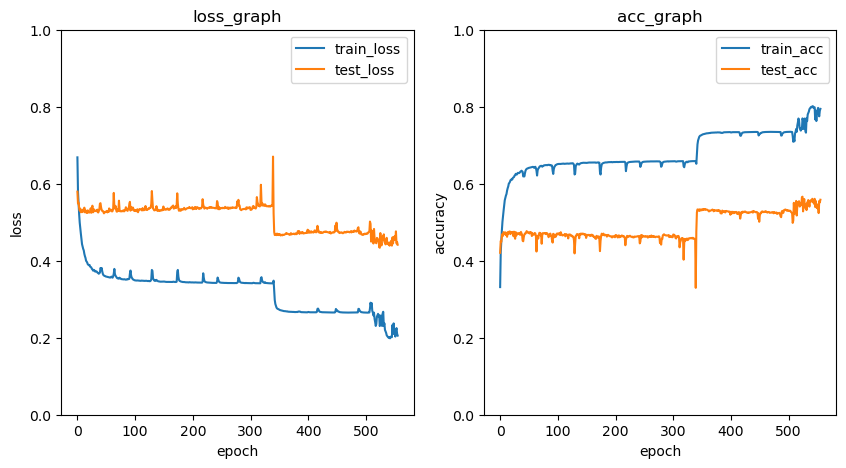

epoch: 557/1000 Step: 124 dice_loss : 0.2047 dice_score: 0.7953: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 557/1000 Step: 32 dice_loss : 0.4425  dice_score: 0.5575: 100%|██████████| 31/31 [00:04<00:00,  6.69it/s]
epoch: 558/1000 Step: 124 dice_loss : 0.2004 dice_score: 0.7996: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 558/1000 Step: 32 dice_loss : 0.4416  dice_score: 0.5584: 100%|██████████| 31/31 [00:04<00:00,  6.55it/s]
epoch: 559/1000 Step: 124 dice_loss : 0.1955 dice_score: 0.8045: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 559/1000 Step: 32 dice_loss : 0.4493  dice_score: 0.5507: 100%|██████████| 31/31 [00:04<00:00,  6.75it/s]
epoch: 560/1000 Step: 124 dice_loss : 0.1981 dice_score: 0.8019: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 560/1000 Step: 32 dice_loss : 0.4422  dice_score: 0.5578: 100%|██████████| 31/31 [00:04<00:00,  6.61it/s]
epoch: 561/1000 Step: 124 dice_loss : 0.1971 dice_score: 0.8029: 100

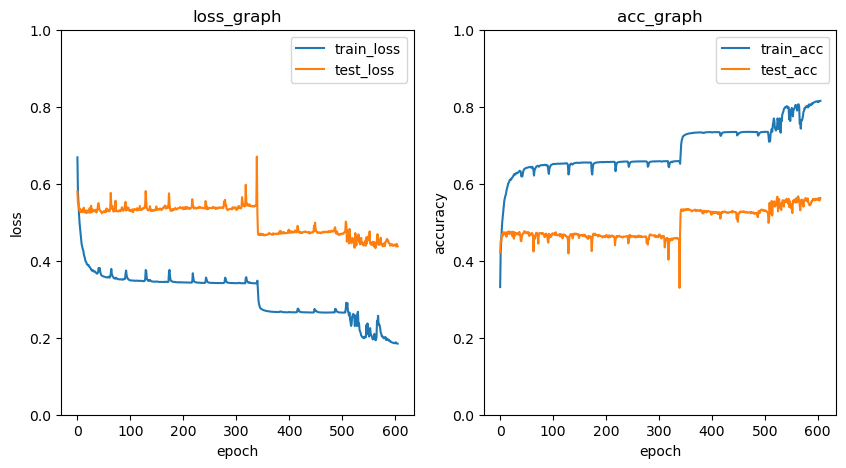

epoch: 607/1000 Step: 124 dice_loss : 0.1853 dice_score: 0.8147: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 607/1000 Step: 32 dice_loss : 0.4374  dice_score: 0.5626: 100%|██████████| 31/31 [00:04<00:00,  6.83it/s]
epoch: 608/1000 Step: 124 dice_loss : 0.1838 dice_score: 0.8162: 100%|██████████| 123/123 [01:03<00:00,  1.94it/s]
test epoch: 608/1000 Step: 32 dice_loss : 0.4403  dice_score: 0.5597: 100%|██████████| 31/31 [00:04<00:00,  6.85it/s]
epoch: 609/1000 Step: 124 dice_loss : 0.1834 dice_score: 0.8166: 100%|██████████| 123/123 [01:02<00:00,  1.98it/s]
test epoch: 609/1000 Step: 32 dice_loss : 0.4395  dice_score: 0.5605: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 610/1000 Step: 124 dice_loss : 0.1836 dice_score: 0.8164: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 610/1000 Step: 32 dice_loss : 0.4451  dice_score: 0.5549: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 611/1000 Step: 124 dice_loss : 0.1830 dice_score: 0.8170: 100

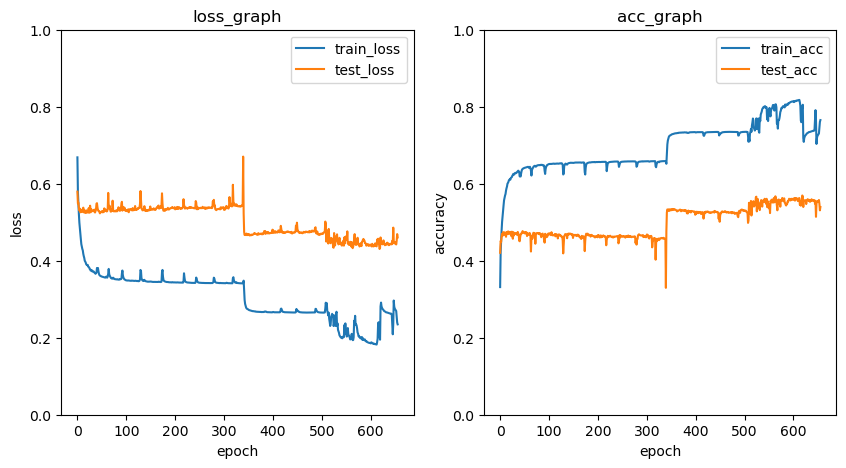

epoch: 657/1000 Step: 124 dice_loss : 0.2257 dice_score: 0.7743: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 657/1000 Step: 32 dice_loss : 0.4744  dice_score: 0.5256: 100%|██████████| 31/31 [00:04<00:00,  6.68it/s]
epoch: 658/1000 Step: 124 dice_loss : 0.2173 dice_score: 0.7827: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 658/1000 Step: 32 dice_loss : 0.4539  dice_score: 0.5461: 100%|██████████| 31/31 [00:04<00:00,  6.69it/s]
epoch: 659/1000 Step: 124 dice_loss : 0.2191 dice_score: 0.7809: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 659/1000 Step: 32 dice_loss : 0.4498  dice_score: 0.5502: 100%|██████████| 31/31 [00:04<00:00,  6.73it/s]
epoch: 660/1000 Step: 124 dice_loss : 0.2107 dice_score: 0.7893: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 660/1000 Step: 32 dice_loss : 0.4594  dice_score: 0.5406: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 661/1000 Step: 124 dice_loss : 0.2036 dice_score: 0.7964: 100

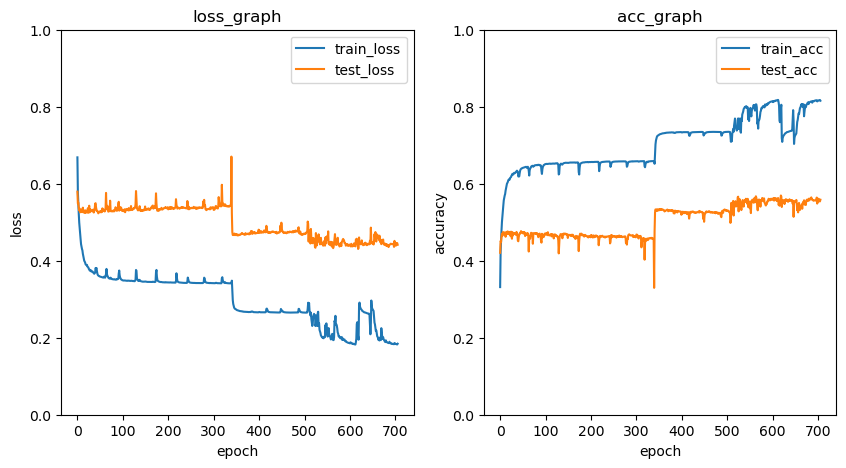

epoch: 707/1000 Step: 124 dice_loss : 0.1835 dice_score: 0.8165: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 707/1000 Step: 32 dice_loss : 0.4410  dice_score: 0.5590: 100%|██████████| 31/31 [00:04<00:00,  6.60it/s]
epoch: 708/1000 Step: 124 dice_loss : 0.2189 dice_score: 0.7811: 100%|██████████| 123/123 [01:03<00:00,  1.95it/s]
test epoch: 708/1000 Step: 32 dice_loss : 0.4808  dice_score: 0.5192: 100%|██████████| 31/31 [00:04<00:00,  6.56it/s]
epoch: 709/1000 Step: 124 dice_loss : 0.2097 dice_score: 0.7903: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 709/1000 Step: 32 dice_loss : 0.4439  dice_score: 0.5561: 100%|██████████| 31/31 [00:04<00:00,  6.50it/s]
epoch: 710/1000 Step: 124 dice_loss : 0.1919 dice_score: 0.8081: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 710/1000 Step: 32 dice_loss : 0.4396  dice_score: 0.5604: 100%|██████████| 31/31 [00:04<00:00,  6.72it/s]
epoch: 711/1000 Step: 124 dice_loss : 0.1893 dice_score: 0.8107: 100

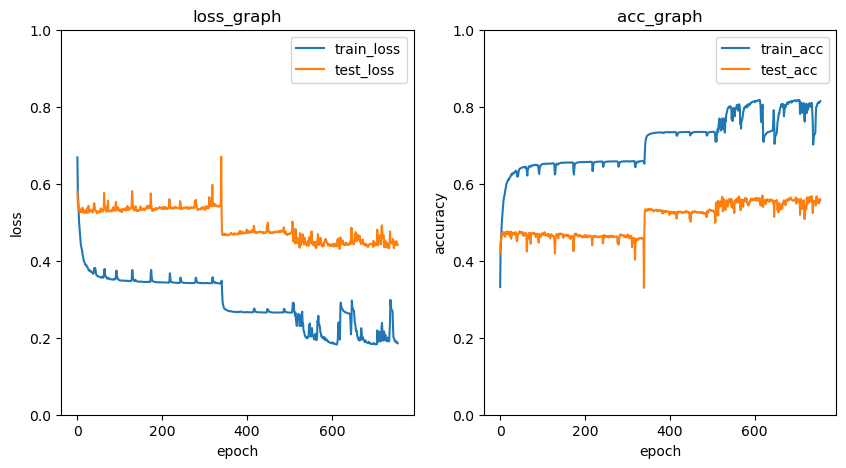

epoch: 757/1000 Step: 124 dice_loss : 0.1854 dice_score: 0.8146: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 757/1000 Step: 32 dice_loss : 0.4419  dice_score: 0.5581: 100%|██████████| 31/31 [00:04<00:00,  6.69it/s]
epoch: 758/1000 Step: 124 dice_loss : 0.1866 dice_score: 0.8134: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 758/1000 Step: 32 dice_loss : 0.4440  dice_score: 0.5560: 100%|██████████| 31/31 [00:04<00:00,  6.70it/s]
epoch: 759/1000 Step: 124 dice_loss : 0.1891 dice_score: 0.8109: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 759/1000 Step: 32 dice_loss : 0.4429  dice_score: 0.5571: 100%|██████████| 31/31 [00:04<00:00,  6.36it/s]
epoch: 760/1000 Step: 124 dice_loss : 0.1877 dice_score: 0.8123: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 760/1000 Step: 32 dice_loss : 0.4425  dice_score: 0.5575: 100%|██████████| 31/31 [00:04<00:00,  6.67it/s]
epoch: 761/1000 Step: 124 dice_loss : 0.1878 dice_score: 0.8122: 100

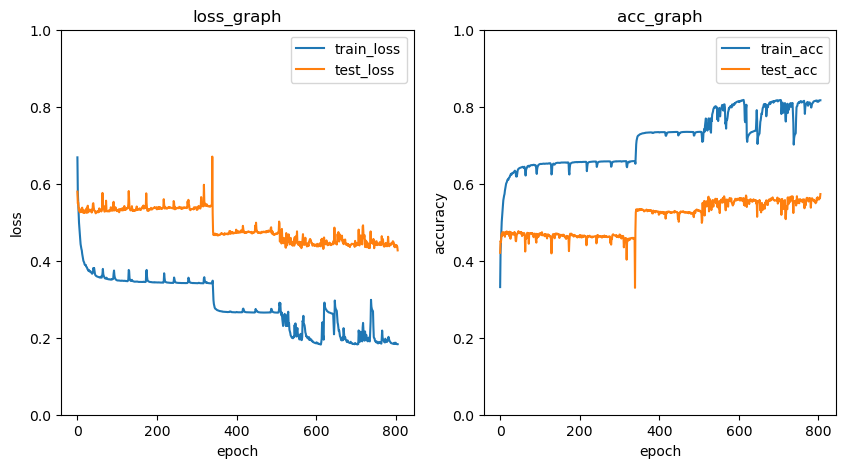

epoch: 807/1000 Step: 124 dice_loss : 0.1833 dice_score: 0.8167: 100%|██████████| 123/123 [01:02<00:00,  1.95it/s]
test epoch: 807/1000 Step: 32 dice_loss : 0.4282  dice_score: 0.5718: 100%|██████████| 31/31 [00:04<00:00,  6.68it/s]
epoch: 808/1000 Step: 124 dice_loss : 0.1856 dice_score: 0.8144: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 808/1000 Step: 32 dice_loss : 0.4409  dice_score: 0.5591: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]
epoch: 809/1000 Step: 124 dice_loss : 0.1859 dice_score: 0.8141: 100%|██████████| 123/123 [01:02<00:00,  1.95it/s]
test epoch: 809/1000 Step: 32 dice_loss : 0.4366  dice_score: 0.5634: 100%|██████████| 31/31 [00:04<00:00,  6.54it/s]
epoch: 810/1000 Step: 124 dice_loss : 0.1832 dice_score: 0.8168: 100%|██████████| 123/123 [01:02<00:00,  1.95it/s]
test epoch: 810/1000 Step: 32 dice_loss : 0.4412  dice_score: 0.5588: 100%|██████████| 31/31 [00:04<00:00,  6.70it/s]
epoch: 811/1000 Step: 124 dice_loss : 0.1866 dice_score: 0.8134: 100

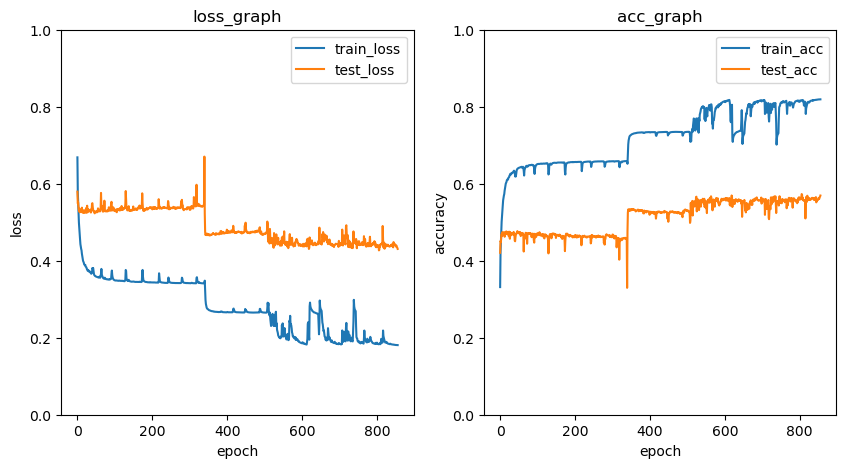

epoch: 857/1000 Step: 124 dice_loss : 0.1806 dice_score: 0.8194: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 857/1000 Step: 32 dice_loss : 0.4330  dice_score: 0.5670: 100%|██████████| 31/31 [00:04<00:00,  6.74it/s]
epoch: 858/1000 Step: 124 dice_loss : 0.1806 dice_score: 0.8194: 100%|██████████| 123/123 [01:02<00:00,  1.95it/s]
test epoch: 858/1000 Step: 32 dice_loss : 0.4361  dice_score: 0.5639: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s]
epoch: 859/1000 Step: 124 dice_loss : 0.1803 dice_score: 0.8197: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 859/1000 Step: 32 dice_loss : 0.4354  dice_score: 0.5646: 100%|██████████| 31/31 [00:04<00:00,  6.75it/s]
epoch: 860/1000 Step: 124 dice_loss : 0.1803 dice_score: 0.8197: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 860/1000 Step: 32 dice_loss : 0.4342  dice_score: 0.5658: 100%|██████████| 31/31 [00:04<00:00,  6.70it/s]
epoch: 861/1000 Step: 124 dice_loss : 0.1803 dice_score: 0.8197: 100

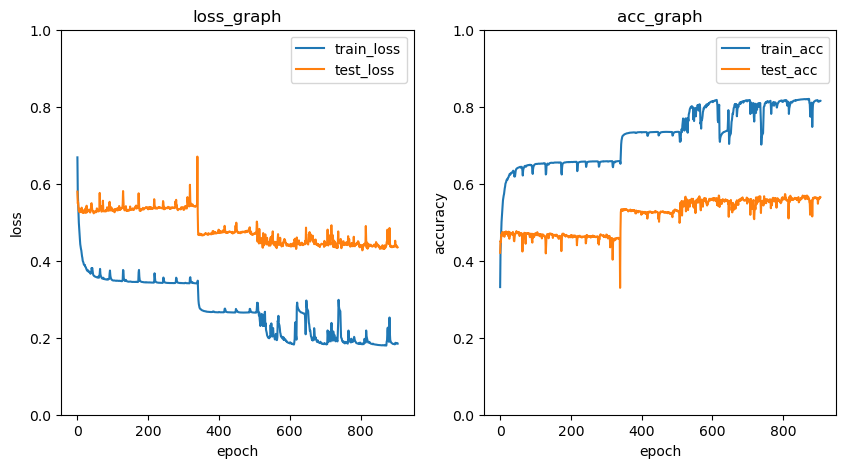

epoch: 907/1000 Step: 124 dice_loss : 0.1839 dice_score: 0.8161: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 907/1000 Step: 32 dice_loss : 0.4356  dice_score: 0.5644: 100%|██████████| 31/31 [00:04<00:00,  6.84it/s]
epoch: 908/1000 Step: 124 dice_loss : 0.1829 dice_score: 0.8171: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 908/1000 Step: 32 dice_loss : 0.4346  dice_score: 0.5654: 100%|██████████| 31/31 [00:04<00:00,  6.88it/s]
epoch: 909/1000 Step: 124 dice_loss : 0.1828 dice_score: 0.8172: 100%|██████████| 123/123 [01:02<00:00,  1.96it/s]
test epoch: 909/1000 Step: 32 dice_loss : 0.4377  dice_score: 0.5623: 100%|██████████| 31/31 [00:04<00:00,  6.71it/s]
epoch: 910/1000 Step: 124 dice_loss : 0.1824 dice_score: 0.8176: 100%|██████████| 123/123 [01:02<00:00,  1.97it/s]
test epoch: 910/1000 Step: 32 dice_loss : 0.4396  dice_score: 0.5604: 100%|██████████| 31/31 [00:04<00:00,  6.78it/s]
epoch: 911/1000 Step: 124 dice_loss : 0.1822 dice_score: 0.8178: 100

KeyboardInterrupt: 

In [5]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/STNT_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')